In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error


import operator
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH = 12
WIDTH = 0.25  # the width of the bars
NARROW = 0.2
XLINE  = 523.21
YLINE  = 0.002
#colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']
colors = ['b','b']
# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]
markersize=20

In [2]:
def get_joined_data():
    """Returns single (joined) dataframe"""
    
    # Combining V100 and P100 on same row for same run
    # We are deleting cases where there is no run for either of the architectures
    # Every column name is appended with the name of the architecture (e.g. "_V100");
    # This includes the `master_index` (e.g `master_index_V100`)

    df_joined = pd.read_parquet('../df_master_joined.parquet')
    df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
    df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
    #import pdb; pdb.set_trace()
    return df_joined

def filter_lt_val(df, val=1e9):
    ##temp_col = df['dram_write_throughput_V100'] + df['dram_read_throughput_V100']
    #temp_col3 = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
    #temp_col = df['dram_write_throughput_P100']
    #temp_col2 = df['dram_read_throughput_P100']
    temp_col4 = df['dram_write_throughput_V100']
    temp_col5 = df['dram_read_throughput_V100'] ## trouble predicting read throughput MAPE=.55 with dram read< 1e9
    #df =df[temp_col>val]
    #df =df[temp_col2>val]
    return df,operator.and_(temp_col4>val,temp_col5>val).values
    import pdb; pdb.set_trace()
    df =df[temp_col4>val]
    df =df[temp_col5>val]
    #df_joined = df_joined[temp_col3>1e9]
    #return df[temp_col > val]
    return df

_columns = None
def get_columns():
    global _columns
    # This is an "empty" dataframe (meaning no rows), containing
    # column names for numerical data only.
    # The column nmaes can be used to index the columns of the
    # scaled data (in master_scaled_data.npy)
    if _columns is None:
        _columns = tuple(pd.read_parquet('../df_column_reference.parquet').columns)
    return _columns


_scaled_data = None
def get_scaled_data(row_index):
    global _scaled_data
    # This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
    # The data has been scaled using the StandardScaler in scikitlearn

    # Notes: 
    #   - The row indices correspond to the `master_index` column of 'df_master.parquet'
    #   - The columns correspond to the columns in 'df_column_reference.parquet'.
    #     (e.g. can use `df.get_loc(column-name)` to get the column index)

    if _scaled_data is None:
        _scaled_data = np.load('../master_scaled_data.npy')
    return _scaled_data[row_index]

def get_data(filter_val=10e9):
    """Returns full data and target vector"""
    
    df = get_joined_data()  # Start with all of df_joined
    
    df,filtered = filter_lt_val(df, filter_val)  # Filter throughput < 1e9
    
    # Training data index and values (values ARE in master_data_scaled)
    data_row_index = df['master_index_P100'].values
    data = get_scaled_data(data_row_index)
    col_indices = []
    for i, col in enumerate(get_columns()):
        if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
            col_indices.append(i)
    data = data[:, col_indices]

    #target_row_index = df['master_index_V100'].values
    #target = get_scaled_data(target_row_index)      
    #target_col_indices = []
    #for i, col in enumerate(get_columns()):
    #    if col in ['dram_read_throughput', 'dram_write_throughput']:
    #        target_col_indices.append(i)
    #target = target[:, target_col_indices[0]] + target[:, target_col_indices[1]]
    ref = (df['dram_read_throughput_V100'] + df['dram_write_throughput_V100']).values
    p100_total_throughput = (df['dram_read_throughput_P100'] + df['dram_write_throughput_P100']).values
    scaler = StandardScaler()
    scaler.fit(ref.reshape(-1, 1))
    target = scaler.transform(ref.reshape(-1, 1)).reshape(ref.shape)

    return data, target, scaler,filtered,p100_total_throughput,ref

def get_data_feature(filter_val=10e9,no_features=['dram_read_throughput','dram_write_throughput']):
    """Returns full data and target vector"""
    
    df = get_joined_data()  # Start with all of df_joined
    
    df,filtered = filter_lt_val(df, filter_val)  # Filter throughput < 1e9
    
    # Training data index and values (values ARE in master_data_scaled)
    import pdb;
    try:
        data_row_index = df['master_index_P100'].values
    except:
        pdb.set_trace()
    data = get_scaled_data(data_row_index)
    col_indices = []
    print(len(no_features))
    for i, col in enumerate(get_columns()):
        if col not in no_features:
            col_indices.append(i)
            print(col)
    data = data[:, col_indices]

    #target_row_index = df['master_index_V100'].values
    #target = get_scaled_data(target_row_index)      
    #target_col_indices = []
    #for i, col in enumerate(get_columns()):
    #    if col in ['dram_read_throughput', 'dram_write_throughput']:
    #        target_col_indices.append(i)
    #target = target[:, target_col_indices[0]] + target[:, target_col_indices[1]]
    ref = (df['dram_read_throughput_V100'] + df['dram_write_throughput_V100']).values
    scaler = StandardScaler()
    scaler.fit(ref.reshape(-1, 1))
    target = scaler.transform(ref.reshape(-1, 1)).reshape(ref.shape)

    return data, target, scaler


def graph_data(x,y,xlabel,ylabel,title,file,num_features=False):
    plt.plot(x, y,'.',color='b',markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if num_features:
        plt.title(title + " - " + num_features + " Features")
    else:
        plt.title(title)
    plt.savefig("Clean_figures/" + file + ".pdf")

## Getting data

In [3]:
data, target, scaler,filtered,p100_tt, v100_tt = get_data(filter_val=0)
df_columns_only = pd.read_parquet('../df_column_reference.parquet')

## Splitting data 

In [4]:
(
    X_train, X_test,
    y_train, y_test,
    filtered_train,
    filtered_test,
) = train_test_split(
    data,
    target,
    filtered,
    random_state=42,
    test_size=.33
)
data.shape

(32291, 112)

In [5]:
filtering = True # Removing target values of 0 
if filtering:
    y_test_filtered = y_test[filtered_test]
    X_test_filtered = X_test[filtered_test]

## Train & Predict with RF model

In [10]:
import pickle
train_new = False
filename = 'RF_reg_model.sav'
if train_new:
    clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
    reg_model = clf.fit(X_train, y_train)
    pickle.dump(reg_model, open(filename, 'wb'))
else:
   clf = pickle.load(open(filename, 'rb'))
   reg_model = pickle.load(open(filename, 'rb'))

In [11]:
if filtering:
    y_test_predict = clf.predict(X_test_filtered)
else:
    y_test_predict = clf.predict(X_test)

## FEATURE IMPORTANCE

In [13]:
"""
1. Variable: l2_atomic_throughput Importance: 0.6166
2. Variable: gld_transactions     Importance: 0.2018
3. Variable: l2_read_transactions Importance: 0.0948
4. Variable: l2_write_throughput  Importance: 0.0091
5. Variable: shared_store_throughput Importance: 0.0087
6. Variable: l2_tex_write_hit_rate Importance: 0.0069
7. Variable: issue_slot_utilization Importance: 0.0066
8. Variable: l2_tex_read_throughput Importance: 0.0044
9. Variable: stall_other          Importance: 0.0035
"""
importances = list(reg_model.feature_importances_)
feature_list = [c for c in df_columns_only.columns 
                if c not in ['dram_read_throughput', 'dram_write_throughput']]
#feature_list = df_columns_only.columns
print(len(feature_list))
feature_importances = [(feature, round(importance, 4)) 
                       for feature, importance in zip(feature_list, importances)]\
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances][:5]

114
Variable: l2_atomic_throughput Importance: 0.618
Variable: l2_read_transactions Importance: 0.2716
Variable: gld_transactions     Importance: 0.0586
Variable: inst_executed        Importance: 0.0115
Variable: l2_write_transactions Importance: 0.009
Variable: stall_memory_throttle Importance: 0.0068
Variable: gst_transactions     Importance: 0.0065
Variable: l2_write_throughput  Importance: 0.0016
Variable: local_memory_overhead Importance: 0.0015
Variable: shared_store_throughput Importance: 0.0014
Variable: local_hit_rate       Importance: 0.0008
Variable: l2_tex_read_throughput Importance: 0.0008
Variable: l2_tex_write_throughput Importance: 0.0008
Variable: l2_atomic_transactions Importance: 0.0008
Variable: gst_requested_throughput Importance: 0.0006
Variable: tex_cache_throughput Importance: 0.0006
Variable: issue_slot_utilization Importance: 0.0006
Variable: l2_tex_write_hit_rate Importance: 0.0005
Variable: stall_inst_fetch     Importance: 0.0005
Variable: sysmem_utilization

[None, None, None, None, None]

In [20]:
not_import = []
for x in feature_importances:
    #print(x)
    if 0 in x or x[1] < 0.0016:
        #print(x[0])
        not_import.append(x[0])
not_import.append('dram_read_throughput')
not_import.append('dram_write_throughput')
not_import.append('dram_write_transactions')
not_import.append('dram_read_transactions')
not_import.append('sysmem_read_utilization')
not_import.append('sysmem_write_utilization')
len(feature_importances)-len(not_import)

2

In [21]:
print("Len of not important: ", len(not_import))

Len of not important:  110


In [22]:
data, target, scaler = get_data_feature(filter_val=0, no_features=not_import)
"""
Important features:
gld_transactions
gst_transactions
l2_read_transactions
l2_write_transactions
l2_write_throughput
inst_executed
l2_atomic_throughput
stall_memory_throttle
"""
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
) = train_test_split(
    data,
    target,
    random_state=42,
    test_size=.33
)

110
gld_transactions
gst_transactions
l2_read_transactions
l2_write_transactions
l2_write_throughput
inst_executed
l2_atomic_throughput
stall_memory_throttle


In [34]:
filtering = True # Removing target values of 0 
if filtering:
    y_test_filtered = y_test[filtered_test]
    X_test_filtered = X_test[filtered_test]

## Random Forest Trained on Reduced Features

In [35]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
filename = "reducefeature_model.sav"
train_new = False
if train_new:
    reg_model = clf.fit(X_train, y_train)
    pickle.dump(reg_model, open(filename, 'wb'))
else:
   clf = pickle.load(open(filename, 'rb'))
   reg_model = pickle.load(open(filename, 'rb'))

In [36]:
if filtering:
    y_test_predict = clf.predict(X_test_filtered)
else:
    y_test_predict = clf.predict(X_test)

In [38]:
errors = abs(y_test_predict - y_test_filtered)

In [40]:
y_test_bytes =  scaler.inverse_transform(y_test_filtered)/1e9
y_test_predict_bytes =  scaler.inverse_transform(y_test_predict)/1e9
errors = abs(y_test_predict_bytes - y_test_bytes)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:", mean_absolute_percentage_error(y_test_bytes, y_test_predict_bytes))

Mean Absolute Error: 15.43
Mean absolute percentage error: 1.0231478397144658


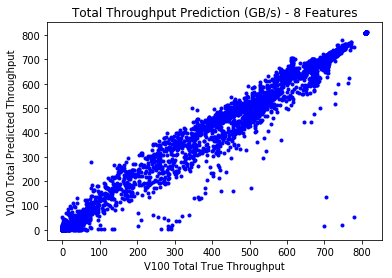

In [41]:
plt.plot(y_test_bytes, y_test_predict_bytes,'.',color='b')
plt.xlabel('V100 Total True Throughput')
plt.ylabel('V100 Total Predicted Throughput')
plt.title('Total Throughput Prediction (GB/s) - 8 Features')
plt.savefig('Throughput_Prediction_Figures/scaled_prediction_8features_reduced_6.80mape.pdf')

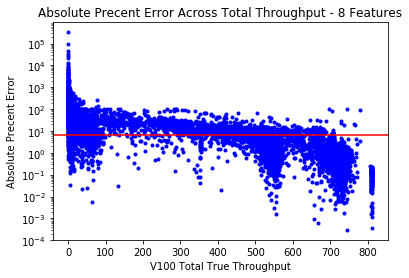

In [42]:
plt.plot(y_test_bytes, (errors/y_test_bytes)*100,'.',color='b')
plt.yscale("log")
plt.axhline(y=6.7, color='r', linestyle='-')
plt.xlabel('V100 Total True Throughput')
plt.ylabel('Absolute Precent Error')
plt.title('Absolute Precent Error Across Total Throughput - 8 Features')
plt.savefig('Throughput_Prediction_Figures/absolute_error_8features_reduced.pdf')